In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import pickle

In [2]:
def display_image(img):
    plt.clf()
    img = np.transpose(img, (2, 0, 1))
    b, g, r = img[0, ...], img[1, ...], img[2, ...]
    rgb = np.asarray([r, g, b])
    transp = np.transpose(rgb, (1, 2, 0))
    plt.imshow(transp)
    plt.show()

In [3]:
folder = 'balanced'
npy_file = '{}/val.input.npy'.format(folder)
val_imgs = np.load(npy_file)
print(val_imgs.shape)

(8279, 30, 30, 3)


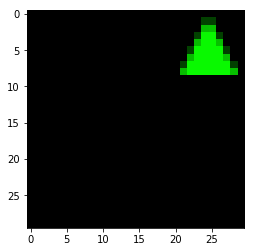

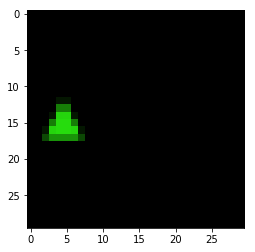

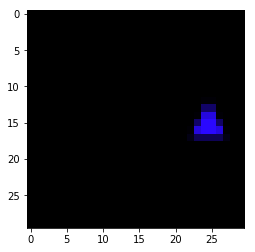

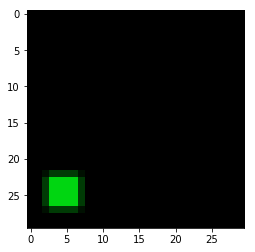

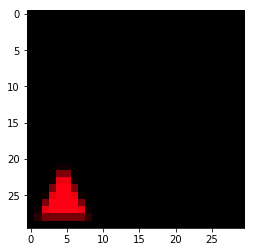

In [4]:
for i in range(5):
    display_image(val_imgs[i])

In [20]:
import glob
image_sets = glob.glob('balanced/*.npy')
all_images = np.concatenate([np.load(npy_file) for npy_file in image_sets])
all_images = all_images/255
all_images.shape

(123398, 30, 30, 3)

In [6]:
all_images.reshape(-1, 3).mean(axis=0)

array([0.01214728, 0.01208014, 0.01196234])

In [7]:
all_images.reshape(-1, 3).std(axis=0)

array([0.09611939, 0.09572092, 0.09523059])

In [21]:
import torch
import torchvision.models as models
import torchvision.transforms
from PIL import Image
import torch.utils.data as data
from torch.utils.data import DataLoader
import os
from tqdm import tqdm_notebook

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [22]:
class ShapesDataset(data.Dataset):
    def __init__(self, images):
        super().__init__()
        self.data = images
        self.transforms = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            # Normalize to (-1, 1)
            torchvision.transforms.Normalize(
                [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
            
        ])
    def __getitem__(self, index):
        image = self.data[index, :, :, :]
        image = self.transforms(image)
        return image

    def __len__(self):
        return self.data.shape[0]

In [23]:
def get_features(model, dataloader, file_id='train'):
    features = []
    for i, x in tqdm_notebook(enumerate(dataloader), total=len(dataloader)):
        x = x.to(device)
        y = model.features(x)
        y = y.view(y.size(0), -1).detach().cpu().numpy()
        features.append(y)
    
    # concatenate all features
    features = np.concatenate(features, axis=0)
    np.save('{}_features.npy'.format(file_id), features)

In [24]:
batch_size = 16

folder = 'balanced'
train_images = np.load('{}/train.large.input.npy'.format(folder))
val_images = np.load('{}/val.input.npy'.format(folder))
test_images = np.load('{}/test.input.npy'.format(folder))

train_dataset = ShapesDataset(train_images)
val_dataset = ShapesDataset(val_images)
test_dataset = ShapesDataset(test_images)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

vgg16 = models.vgg16(pretrained=True)
vgg16.to(device)
vgg16.eval()

get_features(vgg16, train_dataloader, 'train')
get_features(vgg16, val_dataloader, 'valid')
get_features(vgg16, test_dataloader, 'test')

In [25]:
train = np.load('train_features.npy')
valid = np.load('valid_features.npy')
test = np.load('test_features.npy')

In [17]:
train.shape

(74504, 512)

In [8]:
test_images = np.load('{}/test.input.npy'.format(folder))

In [10]:
test_images.shape

(40504, 30, 30, 3)